In [28]:
# Import and Extract CXR files and labels
import boto3
import zipfile
import re
import glob
import shutil
from sagemaker import get_execution_role
role = get_execution_role()

# Declare bucket name, remote file, and destination
my_bucket = 'med-277'
files = {
    'sepsis_reports/CXR_Sep.zip': 'mimic-sepsis-reports.zip',
    'sepsis_reports/Data_Description.csv': 'Data_Description.csv'
}

# Connect to S3 bucket and download file
s3 = boto3.resource('s3')
for orig_file, dest_file in files.items():
    if not os.path.exists(dest_file):
        s3.Bucket(my_bucket).download_file(orig_file, dest_file)
        if dest_file == 'mimic-sepsis-reports.zip':
            with zipfile.ZipFile("mimic-sepsis-reports.zip","r") as zip_ref:
                zip_ref.extractall("mimic-sepsis-reports")
        if dest_file == 'Data_Description.csv':
            shutil.move('Data_Description.csv', "mimic-sepsis-reports/Data_Description.csv")

In [41]:
with zipfile.ZipFile("CXR_Sep_Validation.zip","r") as zip_ref:
    zip_ref.extractall("mimic-sepsis-reports")

In [ ]:
import os

In [4]:
import tensorflow as tf
from matplotlib import pyplot as plt

import re
import collections
import numpy as np
import pandas as pd

import seaborn as sn

In [2]:
def section_text(text):
    """Splits text into sections.
    Assumes text is in a radiology report format, e.g.:
        COMPARISON:  Chest radiograph dated XYZ.
        IMPRESSION:  ABC...
    Given text like this, it will output text from each section, 
    where the section type is determined by the all caps header.
    Returns a three element tuple:
        sections - list containing the text of each section
        section_names - a normalized version of the section name
        section_idx - list of start indices of the text in the section
    """
    p_section = re.compile(
        r'\n ([A-Z ()/,-]+):\s', re.DOTALL)

    sections = list()
    section_names = list()
    section_idx = list()

    idx = 0
    s = p_section.search(text, idx)

    if s:
        sections.append(text[0:s.start(1)])
        section_names.append('preamble')
        section_idx.append(0)

        while s:
            current_section = s.group(1).lower()
            # get the start of the text for this section
            idx_start = s.end()
            # skip past the first newline to avoid some bad parses
            idx_skip = text[idx_start:].find('\n')
            if idx_skip == -1:
                idx_skip = 0

            s = p_section.search(text, idx_start + idx_skip)

            if s is None:
                idx_end = len(text)
            else:
                idx_end = s.start()

            sections.append(text[idx_start:idx_end])
            section_names.append(current_section)
            section_idx.append(idx_start)

    else:
        sections.append(text)
        section_names.append('full report')
        section_idx.append(0)

    section_names = normalize_section_names(section_names)

    # remove empty sections
    # this handles when the report starts with a finding-like statement
    #  .. but this statement is not a section, more like a report title
    #  e.g. p10/p10103318/s57408307
    #    CHEST, PA LATERAL:
    #
    #    INDICATION:   This is the actual section ....
    # it also helps when there are multiple findings sections
    # usually one is empty
    for i in reversed(range(len(section_names))):
        if section_names[i] in ('impression', 'findings'):
            if sections[i].strip() == '':
                sections.pop(i)
                section_names.pop(i)
                section_idx.pop(i)

    if ('impression' not in section_names) & ('findings' not in section_names):
        # create a new section for the final paragraph
        if '\n \n' in sections[-1]:
            sections.append('\n \n'.join(sections[-1].split('\n \n')[1:]))
            sections[-2] = sections[-2].split('\n \n')[0]
            section_names.append('last_paragraph')
            section_idx.append(section_idx[-1] + len(sections[-2]))

    return sections, section_names, section_idx


def normalize_section_names(section_names):
    # first, lower case all
    section_names = [s.lower().strip() for s in section_names]

    frequent_sections = {
        "preamble": "preamble",  # 227885
        "impression": "impression",  # 187759
        "comparison": "comparison",  # 154647
        "indication": "indication",  # 153730
        "findings": "findings",  # 149842
        "examination": "examination",  # 94094
        "technique": "technique",  # 81402
        "history": "history",  # 45624
        "comparisons": "comparison",  # 8686
        "clinical history": "history",  # 7121
        "reason for examination": "indication",  # 5845
        "notification": "notification",  # 5749
        "reason for exam": "indication",  # 4430
        "clinical information": "history",  # 4024
        "exam": "examination",  # 3907
        "clinical indication": "indication",  # 1945
        "conclusion": "impression",  # 1802
        "chest, two views": "findings",  # 1735
        "recommendation(s)": "recommendations",  # 1700
        "type of examination": "examination",  # 1678
        "reference exam": "comparison",  # 347
        "patient history": "history",  # 251
        "addendum": "addendum",  # 183
        "comparison exam": "comparison",  # 163
        "date": "date",  # 108
        "comment": "comment",  # 88
        "findings and impression": "impression",  # 87
        "wet read": "wet read",  # 83
        "comparison film": "comparison",  # 79
        "recommendations": "recommendations",  # 72
        "findings/impression": "impression",  # 47
        "pfi": "history",
        'recommendation': 'recommendations',
        'wetread': 'wet read',
        'ndication': 'impression',  # 1
        'impresson': 'impression',  # 2
        'imprression': 'impression',  # 1
        'imoression': 'impression',  # 1
        'impressoin': 'impression',  # 1
        'imprssion': 'impression',  # 1
        'impresion': 'impression',  # 1
        'imperssion': 'impression',  # 1
        'mpression': 'impression',  # 1
        'impession': 'impression',  # 3
        'findings/ impression': 'impression',  # ,1
        'finding': 'findings',  # ,8
        'findins': 'findings',
        'findindgs': 'findings',  # ,1
        'findgings': 'findings',  # ,1
        'findngs': 'findings',  # ,1
        'findnings': 'findings',  # ,1
        'finidngs': 'findings',  # ,2
        'idication': 'indication',  # ,1
        'reference findings': 'findings',  # ,1
        'comparision': 'comparison',  # ,2
        'comparsion': 'comparison',  # ,1
        'comparrison': 'comparison',  # ,1
        'comparisions': 'comparison'  # ,1
    }

    p_findings = [
        'chest',
        'portable',
        'pa and lateral',
        'lateral and pa',
        'ap and lateral',
        'lateral and ap',
        'frontal and',
        'two views',
        'frontal view',
        'pa view',
        'ap view',
        'one view',
        'lateral view',
        'bone window',
        'frontal upright',
        'frontal semi-upright',
        'ribs',
        'pa and lat'
    ]
    p_findings = re.compile('({})'.format('|'.join(p_findings)))

    main_sections = [
        'impression', 'findings', 'history', 'comparison',
        'addendum'
    ]
    for i, s in enumerate(section_names):
        if s in frequent_sections:
            section_names[i] = frequent_sections[s]
            continue

        main_flag = False
        for m in main_sections:
            if m in s:
                section_names[i] = m
                main_flag = True
                break
        if main_flag:
            continue

        m = p_findings.search(s)
        if m is not None:
            section_names[i] = 'findings'

        # if it looks like it is describing the entire study
        # it's equivalent to findings
        # group similar phrasings for impression

    return section_names


def custom_mimic_cxr_rules():
    custom_section_names = {
        's50913680': 'recommendations',  # files/p11/p11851243/s50913680.txt
        's59363654': 'examination',  # files/p12/p12128253/s59363654.txt
        's59279892': 'technique',  # files/p13/p13150370/s59279892.txt
        's59768032': 'recommendations',  # files/p13/p13249077/s59768032.txt
        's57936451': 'indication',  # files/p14/p14325424/s57936451.txt
        's50058765': 'indication',  # files/p14/p14731346/s50058765.txt
        's53356173': 'examination',  # files/p15/p15898350/s53356173.txt
        's53202765': 'technique',  # files/p16/p16076182/s53202765.txt
        's50808053': 'technique',  # files/p16/p16631485/s50808053.txt
        's51966317': 'indication',  # files/p10/p10817099/s51966317.txt
        's50743547': 'examination',  # files/p11/p11388341/s50743547.txt
        's56451190': 'note',  # files/p11/p11842879/s56451190.txt
        's59067458': 'recommendations',  # files/p11/p11984647/s59067458.txt
        's59215320': 'examination',  # files/p12/p12408912/s59215320.txt
        's55124749': 'indication',  # files/p12/p12428492/s55124749.txt
        's54365831': 'indication',  # files/p13/p13876470/s54365831.txt
        's59087630': 'recommendations',  # files/p14/p14267880/s59087630.txt
        's58157373': 'recommendations',  # files/p15/p15032392/s58157373.txt
        's56482935': 'recommendations',  # files/p15/p15388421/s56482935.txt
        's58375018': 'recommendations',  # files/p15/p15505556/s58375018.txt
        's54654948': 'indication',  # files/p17/p17090359/s54654948.txt
        's55157853': 'examination',  # files/p18/p18975498/s55157853.txt
        's51491012': 'history',  # files/p19/p19314266/s51491012.txt

    }

    custom_indices = {
        's50525523': [201, 349],  # files/p10/p10602608/s50525523.txt
        's57564132': [233, 554],  # files/p10/p10637168/s57564132.txt
        's59982525': [313, 717],  # files/p11/p11989982/s59982525.txt
        's53488209': [149, 475],  # files/p12/p12458657/s53488209.txt
        's54875119': [234, 988],  # files/p13/p13687044/s54875119.txt
        's50196495': [59, 399],  # files/p13/p13894879/s50196495.txt
        's56579911': [59, 218],  # files/p15/p15394326/s56579911.txt
        's52648681': [292, 631],  # files/p15/p15666238/s52648681.txt
        's59889364': [172, 453],  # files/p15/p15835529/s59889364.txt
        's53514462': [73, 377],  # files/p16/p16297706/s53514462.txt
        's59505494': [59, 450],  # files/p16/p16730991/s59505494.txt
        's53182247': [59, 412],  # files/p16/p16770442/s53182247.txt
        's51410602': [47, 320],  # files/p17/p17069955/s51410602.txt
        's56412866': [522, 822],  # files/p17/p17612000/s56412866.txt
        's54986978': [59, 306],  # files/p17/p17912487/s54986978.txt
        's59003148': [262, 505],  # files/p17/p17916384/s59003148.txt
        's57150433': [61, 394],  # files/p18/p18335791/s57150433.txt
        's56760320': [219, 457],  # files/p18/p18418794/s56760320.txt
        's59562049': [158, 348],  # files/p18/p18502016/s59562049.txt
        's52674888': [145, 296],  # files/p19/p19381919/s52674888.txt
        's55258338': [192, 568],  # files/p13/p13719117/s55258338.txt
        's59330497': [140, 655],  # files/p15/p15479218/s59330497.txt
        's52119491': [179, 454],  # files/p17/p17959278/s52119491.txt
        # below have no findings at all in the entire report
        's58235663': [0, 0],  # files/p11/p11573679/s58235663.txt
        's50798377': [0, 0],  # files/p12/p12632853/s50798377.txt
        's54168089': [0, 0],  # files/p14/p14463099/s54168089.txt
        's53071062': [0, 0],  # files/p15/p15774521/s53071062.txt
        's56724958': [0, 0],  # files/p16/p16175671/s56724958.txt
        's54231141': [0, 0],  # files/p16/p16312859/s54231141.txt
        's53607029': [0, 0],  # files/p17/p17603668/s53607029.txt
        's52035334': [0, 0],  # files/p19/p19349312/s52035334.txt
    }

    return custom_section_names, custom_indices

In [3]:
# Chest report parser function
def cxr_report_parser(text):
    try:
        sections, section_names, section_start_idx = section_text(text.strip())
        impression = ''
        for i in range(len(section_names)):
            if section_names[i] == 'impression':
                impression = sections[i]
            # Can add other sections if you want
            if section_names[i] == 'findings':
                findings = sections[i]
        return impression.strip()
    except:
        return np.NaN

In [104]:
# Read and parse data from input CSV files
train_dir = 'mimic-sepsis-reports/CXR_Sep'
valid_dir = 'mimic-sepsis-reports/CXR_Sep_Valid'
data_columns = pd.read_csv('mimic-sepsis-reports/Data_Description.csv')

In [105]:
print("Train Set Len: ", len(os.listdir(train_dir)))
print("Valid Set Len: ", len(os.listdir(valid_dir)))

Train Set Len:  1973
Valid Set Len:  1469


In [121]:
train_data_df = None
valid_data_df = None

In [122]:
cnt = 0
for i in os.listdir(train_dir):
    if i == '.ipynb_checkpoints':
        continue
        
    data = pd.read_csv(os.path.join(train_dir, i), header=None)
    data.columns = data_columns['name'][:300]
    
    # Sepsis label
    # sepsis_label = data['Sepsis']
    
    # Structured data (e.g. labs). There are a significant number of missing values, so a simple solution
    # is to use mean imputation. You are welcome to use other imputation methods. You will also want to
    # reduce the number of columns based on clinically relevant variables/missingness.
    
#     structured_columns = [
#         'HR', 
#         'SBP', 
#         'MAP', 
#         'DBP', 
#         'Resp', 
#         'BUN', 
#         'Calcium', 
#         'Chloride', 
#         'Glucose', 
#         'Lactate', 
#         'Phosphate', 
#         'Sodium', 
#         'TEXT'
#     ] # You'll probably want to include more columns
    
    vital_features = [
        'HR',
        'O2Sat',
        'Temp',
        'SBP',
        'MAP',
        'DBP',
        'Resp',
        'EtCO2'
    ]
    
    diagnosis_features = [
        'BaseExcess',
        'HCO3',
        'FiO2',
        'pH',
        'PaCO2',
        'SaO2',
        'AST',
        'BUN',
        'Alkalinephos',
        'Calcium',
        'Chloride',
        'Creatinine',
        'BilirubinDirect',
        'Glucose',
        'Lactate',
        'Magnesium',
        'Phosphate',
        'Potassium',
        'BilirubinTotal',
        'TroponinI',
        'Hct',
        'Hgb',
        'PTT',
        'WBC',
        'Fibrinogen',
        'Platelets',
        'PaO2',
        'BNP',
        'Sodium',
        'Procalcitonin',
        'CRP',
        'Ammonia',
        'Hgb_A1C',
        'lymphocytes',
        'lymphocytes_differential',
        'albumin',
        'ALT',
        'D_Dimer',
        'Ferritin',
        'Red_cell_width',
        'Sedimentation_Rate',
        'LDH'
    ]

    other_features = [
        'age',
        'gender',
        'ICULOS',
        'MICU',
        'SICU',
        'preLOS',
        'ICULOS',
        'TempSIRS',
        'RESPSIRS',
        'HRSIRS',
        'WBCSIRS'
    ]
    
    sofa_features = [
        'RESPSOFA',
        'coaSOFA',
        'liverSOFA',
        'CVSSOFA',
        'perfusionSOFA',
        'renalSOFA',
        'CMSsofa'
    ]
    
    med_features = [
        'on_vent',
        'on_anesthesia',
        'on_anticoagulants',
        'on_anticonvulsants',
        'on_antipsychotics',
        'on_bleed_reversal',
        'on_vasodilator',
        'on_antihypertensive',
        'on_antiarrhythmic',
        'on_prostacyclin',
        'on_neuro_block',
        'on_pain_med'
    ]
    
    comorbidities = [
        'has_intravascular_coagulation',
        'has_necrotizing_fasciitis',
        'has_tumor_lysis_syndrome',
        'has_shock',
        'has_metastatic_cancer',
        'has_stemi',
        'has_myeloblastic_leukemia',
        'has_liver_failure',
        'has_malignant_pleural_effusion',
        'has_pneumothorax',
        'has_cachexia',
        'has_coma',
        'has_peritonitis',
        'has_lymphoma',
        'has_carditis',
        'has_septic_empolism',
        'has_coagulation_defect',
        'has_primary_lung_cancer',
        'has_lymphoid_leukemia',
        'has_pulmonary_embolism',
        'has_pericardial_effusion',
        'has_cerebral_infarction',
        'has_meningitis',
        'has_malignant_liver_cancer',
        'has_gi_hemorrhage',
        'has_acute_renal_failure',
        'has_chronic_liver_disease',
        'has_neutropenia',
        'has_cardiac_arrythmia',
        'has_malnutrition',
        'has_pulmonary_heart_disease',
        'has_ckd',
        'has_plasma_protein_disorder',
        'has_aplasia',
        'has_aspiration_pneumonitis',
        'has_ami',
        'has_chf',
        'has_encephalopathy',
        'has_thrombocytopenia',
        'has_coronary_artery_disease',
        'has_copd',
        'has_diabetes',
        'has_hiv',
        'has_hypertension',
        'has_obesity',
        'has_brain_condition',
        'has_pulmonary_condition',
        'has_valve_disease',
        'has_uti',
        'has_anemia',
        'has_pneumonia',
        'has_hyperlipidemia',
        'has_depression',
        'has_bacteremia',
        'has_reflux_disease',
        'has_hypothyroidism',
        'has_insulin'
    ]
    
    structured_columns = vital_features + diagnosis_features + other_features + sofa_features + med_features + comorbidities + ['Sepsis', 'TEXT']
        
    structured_data = data[structured_columns]
    
    # Reports. You can use the parser function to extract whatever section you want from the report.
    structured_data['TEXT'] = structured_data['TEXT'].apply(cxr_report_parser)
    structured_data['TEXT'] = structured_data['TEXT'].fillna(method='ffill')
    structured_data['TEXT'] = structured_data['TEXT'].fillna('')
    
    # Patient ID
    patient_id = i[38:46]
    structured_data.insert(loc=0, column='patient_id', value=patient_id)
    
    # Time
    time_seq = [i for i in range(1, structured_data.shape[0] + 1)]
    structured_data.insert(loc=1, column='time', value=time_seq)
        
    if train_data_df is None:
        train_data_df = structured_data
    else:
        train_data_df = pd.concat([train_data_df, structured_data], ignore_index=True)        
        
    cnt += 1
    if cnt % 100 == 0:
        print(f"Processed train files: ", cnt)
        
print(f"Processed train files: ", cnt)

/tmp/ipykernel_23384/509680547.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  structured_data['TEXT'] = structured_data['TEXT'].apply(cxr_report_parser)
/tmp/ipykernel_23384/509680547.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  structured_data['TEXT'] = structured_data['TEXT'].fillna(method='ffill')
/tmp/ipykernel_23384/509680547.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

Processed train files:  100
Processed train files:  200
Processed train files:  300
Processed train files:  400
Processed train files:  500
Processed train files:  600
Processed train files:  700
Processed train files:  800
Processed train files:  900
Processed train files:  1000
Processed train files:  1100
Processed train files:  1200
Processed train files:  1300
Processed train files:  1400
Processed train files:  1500
Processed train files:  1600
Processed train files:  1700
Processed train files:  1800
Processed train files:  1900
Processed train files:  1972


In [123]:
data_columns.name[:300]

0                                         HR
1                                    HR_base
2                                   HR_delta
3                                    HR_tslm
4                                      O2Sat
                       ...                  
295            AKI-T0 (has not been applied)
296        time_to_AKI(has not been applied)
297    baseline_T0_AKI(has not been applied)
298                                      AKI
299                                     TEXT
Name: name, Length: 300, dtype: object

In [124]:
valid_data_columns = data_columns[data_columns.name != "AKI"]
valid_data_columns.reset_index(drop=True)
valid_data_columns.shape

(300, 4)

In [125]:
cnt = 0
for i in os.listdir(valid_dir):
    if i == '.ipynb_checkpoints':
        continue
        
    data = pd.read_csv(os.path.join(valid_dir, i), header=None)
    data.columns = valid_data_columns['name'][:299]
    
    # Sepsis label
    # sepsis_label = data['Sepsis']
    
    # Structured data (e.g. labs). There are a significant number of missing values, so a simple solution
    # is to use mean imputation. You are welcome to use other imputation methods. You will also want to
    # reduce the number of columns based on clinically relevant variables/missingness.
    
#     structured_columns = [
#         'HR', 
#         'SBP', 
#         'MAP', 
#         'DBP', 
#         'Resp', 
#         'BUN', 
#         'Calcium', 
#         'Chloride', 
#         'Glucose', 
#         'Lactate', 
#         'Phosphate', 
#         'Sodium', 
#         'TEXT'
#     ] # You'll probably want to include more columns
    
    vital_features = [
        'HR',
        'O2Sat',
        'Temp',
        'SBP',
        'MAP',
        'DBP',
        'Resp',
        'EtCO2'
    ]
    
    diagnosis_features = [
        'BaseExcess',
        'HCO3',
        'FiO2',
        'pH',
        'PaCO2',
        'SaO2',
        'AST',
        'BUN',
        'Alkalinephos',
        'Calcium',
        'Chloride',
        'Creatinine',
        'BilirubinDirect',
        'Glucose',
        'Lactate',
        'Magnesium',
        'Phosphate',
        'Potassium',
        'BilirubinTotal',
        'TroponinI',
        'Hct',
        'Hgb',
        'PTT',
        'WBC',
        'Fibrinogen',
        'Platelets',
        'PaO2',
        'BNP',
        'Sodium',
        'Procalcitonin',
        'CRP',
        'Ammonia',
        'Hgb_A1C',
        'lymphocytes',
        'lymphocytes_differential',
        'albumin',
        'ALT',
        'D_Dimer',
        'Ferritin',
        'Red_cell_width',
        'Sedimentation_Rate',
        'LDH'
    ]

    other_features = [
        'age',
        'gender',
        'ICULOS',
        'MICU',
        'SICU',
        'preLOS',
        'ICULOS',
        'TempSIRS',
        'RESPSIRS',
        'HRSIRS',
        'WBCSIRS'
    ]
    
    sofa_features = [
        'RESPSOFA',
        'coaSOFA',
        'liverSOFA',
        'CVSSOFA',
        'perfusionSOFA',
        'renalSOFA',
        'CMSsofa'
    ]
    
    med_features = [
        'on_vent',
        'on_anesthesia',
        'on_anticoagulants',
        'on_anticonvulsants',
        'on_antipsychotics',
        'on_bleed_reversal',
        'on_vasodilator',
        'on_antihypertensive',
        'on_antiarrhythmic',
        'on_prostacyclin',
        'on_neuro_block',
        'on_pain_med'
    ]
    
    comorbidities = [
        'has_intravascular_coagulation',
        'has_necrotizing_fasciitis',
        'has_tumor_lysis_syndrome',
        'has_shock',
        'has_metastatic_cancer',
        'has_stemi',
        'has_myeloblastic_leukemia',
        'has_liver_failure',
        'has_malignant_pleural_effusion',
        'has_pneumothorax',
        'has_cachexia',
        'has_coma',
        'has_peritonitis',
        'has_lymphoma',
        'has_carditis',
        'has_septic_empolism',
        'has_coagulation_defect',
        'has_primary_lung_cancer',
        'has_lymphoid_leukemia',
        'has_pulmonary_embolism',
        'has_pericardial_effusion',
        'has_cerebral_infarction',
        'has_meningitis',
        'has_malignant_liver_cancer',
        'has_gi_hemorrhage',
        'has_acute_renal_failure',
        'has_chronic_liver_disease',
        'has_neutropenia',
        'has_cardiac_arrythmia',
        'has_malnutrition',
        'has_pulmonary_heart_disease',
        'has_ckd',
        'has_plasma_protein_disorder',
        'has_aplasia',
        'has_aspiration_pneumonitis',
        'has_ami',
        'has_chf',
        'has_encephalopathy',
        'has_thrombocytopenia',
        'has_coronary_artery_disease',
        'has_copd',
        'has_diabetes',
        'has_hiv',
        'has_hypertension',
        'has_obesity',
        'has_brain_condition',
        'has_pulmonary_condition',
        'has_valve_disease',
        'has_uti',
        'has_anemia',
        'has_pneumonia',
        'has_hyperlipidemia',
        'has_depression',
        'has_bacteremia',
        'has_reflux_disease',
        'has_hypothyroidism',
        'has_insulin'
    ]
    
    structured_columns = vital_features + diagnosis_features + other_features + sofa_features + med_features + comorbidities + ['Sepsis', 'TEXT']
        
    structured_data = data[structured_columns]
    
    # Reports. You can use the parser function to extract whatever section you want from the report.
    structured_data['TEXT'] = structured_data['TEXT'].apply(cxr_report_parser)
    structured_data['TEXT'] = structured_data['TEXT'].fillna(method='ffill')
    structured_data['TEXT'] = structured_data['TEXT'].fillna('')
    
    # Patient ID
    patient_id = i[38:46]
    structured_data.insert(loc=0, column='patient_id', value=patient_id)
    
    # Time
    time_seq = [i for i in range(1, structured_data.shape[0] + 1)]
    structured_data.insert(loc=1, column='time', value=time_seq)
        
    if valid_data_df is None:
        valid_data_df = structured_data
    else:
        valid_data_df = pd.concat([valid_data_df, structured_data], ignore_index=True)        
        
    cnt += 1
    if cnt % 100 == 0:
        print(f"Processed valid files: ", cnt)
        
print(f"Processed valid files: ", cnt)


/tmp/ipykernel_23384/3567179575.py:192: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  structured_data['TEXT'] = structured_data['TEXT'].apply(cxr_report_parser)
/tmp/ipykernel_23384/3567179575.py:193: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  structured_data['TEXT'] = structured_data['TEXT'].fillna(method='ffill')
/tmp/ipykernel_23384/3567179575.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

Processed valid files:  100
Processed valid files:  200
Processed valid files:  300
Processed valid files:  400
Processed valid files:  500
Processed valid files:  600
Processed valid files:  700
Processed valid files:  800
Processed valid files:  900
Processed valid files:  1000
Processed valid files:  1100
Processed valid files:  1200
Processed valid files:  1300
Processed valid files:  1400
Processed valid files:  1468


In [126]:
train_data_df.shape

(97512, 141)

In [127]:
valid_data_df.shape

(110182, 141)

In [128]:
train_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97512 entries, 0 to 97511
Columns: 141 entries, patient_id to TEXT
dtypes: float64(138), int64(1), object(2)
memory usage: 104.9+ MB


In [129]:
valid_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110182 entries, 0 to 110181
Columns: 141 entries, patient_id to TEXT
dtypes: float64(138), int64(1), object(2)
memory usage: 118.5+ MB


In [130]:
rows = train_data_df.shape[0] 
cols = train_data_df.shape[1]
column_nan_count = collections.Counter()

for col in range(cols):
    column_nan_count[train_data_df.columns[col]] = train_data_df.isnull().sum()[col]

In [131]:
num = 0
frequent_nan_features = []
for feature, count in column_nan_count.items():
    nan_percent = (count / rows) * 100
    
    if nan_percent > 20:
        frequent_nan_features.append(feature)
        print(feature, count, nan_percent)
        num += 1

print("Total number of features: ", cols)
print("Number of features with more than 20% NaN values: ", num)

O2Sat 60591 62.13696775781442
EtCO2 90924 93.2439084420379
BaseExcess 34019 34.88698826811059
HCO3 96269 98.72528509311674
FiO2 97512 100.0
pH 26589 27.26741324144721
PaCO2 32816 33.65329395356469
SaO2 69727 71.50607104766593
AST 57755 59.22860776109607
Alkalinephos 61563 63.13376815161212
BilirubinDirect 93850 96.2445647715153
Lactate 45282 46.437361555500864
BilirubinTotal 60881 62.43436705226023
TroponinI 80710 82.76930018869473
PTT 22861 23.444294035605875
Fibrinogen 76313 78.26011157601116
PaO2 32707 33.5415128394454
BNP 95121 97.5479940930347
Procalcitonin 97512 100.0
CRP 95861 98.30687505127574
Ammonia 97017 99.49237016982525
Hgb_A1C 97017 99.49237016982525
lymphocytes 97512 100.0
lymphocytes_differential 67301 69.01817212240545
albumin 71984 73.8206579703011
ALT 60827 62.37898925260481
D_Dimer 96736 99.20420050865535
Ferritin 94424 96.83321027155633
Red_cell_width 97512 100.0
Sedimentation_Rate 96576 99.04011813930593
LDH 73710 75.59069652965789
on_vent 97475 99.96205595208795


In [132]:
train_data_df_clean = train_data_df.drop(columns = frequent_nan_features)
train_data_df_clean.shape

(97512, 109)

In [133]:
valid_data_df_clean = valid_data_df.drop(columns = frequent_nan_features)
valid_data_df_clean.shape

(110182, 109)

In [134]:
numeric_columns = list(train_data_df_clean.select_dtypes(include=['number']).columns)

for col in numeric_columns:
    train_data_df_clean[col] = train_data_df_clean[col].fillna(train_data_df_clean[col].mean())
train_data_df_clean


/tmp/ipykernel_23384/2032673233.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_df_clean[col] = train_data_df_clean[col].fillna(train_data_df_clean[col].mean())


name,patient_id,time,HR,Temp,SBP,MAP,DBP,Resp,BUN,Calcium,...,has_anemia,has_pneumonia,has_hyperlipidemia,has_depression,has_bacteremia,has_reflux_disease,has_hypothyroidism,has_insulin,Sepsis,TEXT
0,25142978,1,85.366311,36.938694,121.789967,79.274046,63.924287,19.311585,24.373042,7.715339,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,
1,25142978,2,85.366311,36.938694,121.789967,79.274046,63.924287,19.311585,24.373042,7.715339,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,
2,25142978,3,85.366311,36.938694,121.789967,79.274046,63.924287,19.311585,24.373042,7.715339,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,
3,25142978,4,109.000000,36.938694,75.000000,42.000000,31.000000,19.311585,24.373042,4.330800,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,
4,25142978,5,92.800000,36.938694,100.000000,63.000000,48.800000,15.200000,13.000000,4.290700,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97507,20644814,65,106.000000,36.440000,138.000000,88.000000,73.000000,33.000000,7.000000,9.300000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"1. Interval placement of a feeding tube, whic..."
97508,20644814,66,109.000000,36.440000,134.000000,93.000000,83.000000,36.000000,7.000000,9.300000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"1. Interval placement of a feeding tube, whic..."
97509,20644814,67,116.000000,36.440000,145.000000,94.000000,76.000000,36.000000,7.000000,9.300000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"1. Interval placement of a feeding tube, whic..."
97510,20644814,68,113.000000,36.440000,133.000000,83.000000,65.000000,36.000000,7.000000,9.300000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"1. Interval placement of a feeding tube, whic..."


In [135]:
train_data_df_clean.dropna(inplace=True)
train_data_df_clean.shape

/home/ec2-user/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


(97509, 109)

In [136]:
numeric_columns = list(valid_data_df_clean.select_dtypes(include=['number']).columns)

for col in numeric_columns:
    valid_data_df_clean[col] = valid_data_df_clean[col].fillna(valid_data_df_clean[col].mean())
valid_data_df_clean


/tmp/ipykernel_23384/718714252.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data_df_clean[col] = valid_data_df_clean[col].fillna(valid_data_df_clean[col].mean())


name,patient_id,time,HR,Temp,SBP,MAP,DBP,Resp,BUN,Calcium,...,has_anemia,has_pneumonia,has_hyperlipidemia,has_depression,has_bacteremia,has_reflux_disease,has_hypothyroidism,has_insulin,Sepsis,TEXT
0,28748915,1,93.0,33.71,121.919617,71.5,62.733473,21.0,30.359004,5.012500,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,
1,28748915,2,94.0,34.00,121.919617,63.0,62.733473,27.0,30.359004,5.012500,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,
2,28748915,3,95.0,34.70,121.919617,65.5,62.733473,24.0,30.359004,5.172900,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,
3,28748915,4,102.0,35.80,121.919617,65.0,62.733473,29.5,30.359004,5.172900,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,
4,28748915,5,113.0,37.00,121.919617,63.0,62.733473,32.0,32.000000,6.300000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110177,23921396,3,65.0,36.56,116.000000,67.0,52.000000,9.0,30.359004,7.665628,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,Left IJ central venous catheter tip in the dis...
110178,23921396,4,77.0,36.56,140.000000,77.0,56.000000,15.5,64.000000,8.800000,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,Left IJ central venous catheter tip in the dis...
110179,23921396,5,77.0,36.56,116.000000,72.0,56.000000,13.0,64.000000,8.800000,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,Left IJ central venous catheter tip in the dis...
110180,23921396,6,66.0,36.56,117.000000,67.0,51.000000,16.0,64.000000,8.800000,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,Left IJ central venous catheter tip in the dis...


In [137]:
valid_data_df_clean.dropna(inplace=True)
valid_data_df_clean.shape

/home/ec2-user/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


(110157, 109)

In [138]:
med_features = [i for i in med_features if i not in frequent_nan_features]
comorbidities = [i for i in comorbidities if i not in frequent_nan_features]

train_data_df_clean[['Sepsis']] = train_data_df_clean[['Sepsis']].astype(int)
train_data_df_clean[med_features] = train_data_df_clean[med_features].astype(int)
train_data_df_clean[comorbidities] = train_data_df_clean[comorbidities].astype(int)
train_data_df_clean.reset_index(drop=True, inplace=True)
train_data_df_clean.head()

/home/ec2-user/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


name,patient_id,time,HR,Temp,SBP,MAP,DBP,Resp,BUN,Calcium,...,has_anemia,has_pneumonia,has_hyperlipidemia,has_depression,has_bacteremia,has_reflux_disease,has_hypothyroidism,has_insulin,Sepsis,TEXT
0,25142978,1,85.366311,36.938694,121.789967,79.274046,63.924287,19.311585,24.373042,7.715339,...,0,0,0,0,0,0,1,0,0,
1,25142978,2,85.366311,36.938694,121.789967,79.274046,63.924287,19.311585,24.373042,7.715339,...,0,0,0,0,0,0,1,0,0,
2,25142978,3,85.366311,36.938694,121.789967,79.274046,63.924287,19.311585,24.373042,7.715339,...,0,0,0,0,0,0,1,0,0,
3,25142978,4,109.000000,36.938694,75.000000,42.000000,31.000000,19.311585,24.373042,4.330800,...,0,0,0,0,0,0,1,0,0,
4,25142978,5,92.800000,36.938694,100.000000,63.000000,48.800000,15.200000,13.000000,4.290700,...,0,0,0,0,0,0,1,0,0,


In [139]:
med_features = [i for i in med_features if i not in frequent_nan_features]
comorbidities = [i for i in comorbidities if i not in frequent_nan_features]

valid_data_df_clean[med_features] = valid_data_df_clean[med_features].astype(int)
valid_data_df_clean[comorbidities] = valid_data_df_clean[comorbidities].astype(int)
valid_data_df_clean.reset_index(drop=True, inplace=True)
valid_data_df_clean.head()

/home/ec2-user/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


name,patient_id,time,HR,Temp,SBP,MAP,DBP,Resp,BUN,Calcium,...,has_anemia,has_pneumonia,has_hyperlipidemia,has_depression,has_bacteremia,has_reflux_disease,has_hypothyroidism,has_insulin,Sepsis,TEXT
0,28748915,1,93.0,33.71,121.919617,71.5,62.733473,21.0,30.359004,5.0125,...,0,0,0,0,1,0,0,1,1.0,
1,28748915,2,94.0,34.00,121.919617,63.0,62.733473,27.0,30.359004,5.0125,...,0,0,0,0,1,0,0,1,1.0,
2,28748915,3,95.0,34.70,121.919617,65.5,62.733473,24.0,30.359004,5.1729,...,0,0,0,0,1,0,0,1,1.0,
3,28748915,4,102.0,35.80,121.919617,65.0,62.733473,29.5,30.359004,5.1729,...,0,0,0,0,1,0,0,1,1.0,
4,28748915,5,113.0,37.00,121.919617,63.0,62.733473,32.0,32.000000,6.3000,...,0,0,0,0,1,0,0,1,1.0,


In [140]:
train_data_df_clean.to_pickle('data/processed_train_data.pkl')

In [141]:
valid_data_df_clean.to_pickle('data/processed_valid_data.pkl')

In [4]:
train_data_df_clean = pd.read_pickle('data/processed_train_data.pkl')

In [5]:
valid_data_df_clean = pd.read_pickle('data/processed_valid_data.pkl')

In [6]:
train_data_df_clean.shape

(97509, 109)

In [7]:
valid_data_df_clean.shape

(110157, 109)

In [8]:
train_text_data_df_clean = train_data_df_clean['TEXT']
train_structured_data_df_clean = train_data_df_clean.drop(columns = ['TEXT'])

In [9]:
valid_text_data_df_clean = valid_data_df_clean['TEXT']
valid_structured_data_df_clean = valid_data_df_clean.drop(columns = ['TEXT'])

Baseline: Logistic Regression, Random Forest

In [190]:
train_structured_data_df_clean.shape

(97509, 108)

In [191]:
train_structured_data_df_clean.head()

name,patient_id,time,HR,Temp,SBP,MAP,DBP,Resp,BUN,Calcium,...,has_uti,has_anemia,has_pneumonia,has_hyperlipidemia,has_depression,has_bacteremia,has_reflux_disease,has_hypothyroidism,has_insulin,Sepsis
0,25142978,1,85.366311,36.938694,121.789967,79.274046,63.924287,19.311585,24.373042,7.715339,...,0,0,0,0,0,0,0,1,0,0
1,25142978,2,85.366311,36.938694,121.789967,79.274046,63.924287,19.311585,24.373042,7.715339,...,0,0,0,0,0,0,0,1,0,0
2,25142978,3,85.366311,36.938694,121.789967,79.274046,63.924287,19.311585,24.373042,7.715339,...,0,0,0,0,0,0,0,1,0,0
3,25142978,4,109.000000,36.938694,75.000000,42.000000,31.000000,19.311585,24.373042,4.330800,...,0,0,0,0,0,0,0,1,0,0
4,25142978,5,92.800000,36.938694,100.000000,63.000000,48.800000,15.200000,13.000000,4.290700,...,0,0,0,0,0,0,0,1,0,0


In [192]:
train_set, train_labels = train_structured_data_df_clean.drop(columns = ['Sepsis', 'patient_id', 'time']), train_structured_data_df_clean['Sepsis']


In [193]:
valid_set, valid_labels = valid_structured_data_df_clean.drop(columns = ['Sepsis', 'patient_id', 'time']), valid_structured_data_df_clean['Sepsis']


### Baseline model

In [21]:
from sklearn.ensemble import RandomForestClassifier

In [5]:
from sklearn.metrics import confusion_matrix

In [153]:
rf_clf = RandomForestClassifier()
rf_clf.fit(train_set, train_labels)

RandomForestClassifier()

In [154]:
predictions = rf_clf.predict(valid_set)

In [155]:
print("Train set score: ", rf_clf.score(train_set, train_labels))
print("Test set score: ", rf_clf.score(valid_set, valid_labels))

print("Confusion matrix: ")
cm = confusion_matrix(valid_labels, predictions,  labels = [1, 0])
print(cm)

TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("Sensitivity, hit rate, recall, or true positive rate: ", TPR)

# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("Specificity or true negative rate: ", TNR)

# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Precision or positive predictive value: ", PPV)

# Negative predictive value
NPV = TN/(TN+FN)
print("Negative predictive value: ", NPV)

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("Fall out or false positive rate: ", FPR)

# False negative rate
FNR = FN/(TP+FN)
print("False negative rate: ", FNR)

# False discovery rate
FDR = FP/(TP+FP)
print("False discovery rate: ", FDR)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall accuracy: ", ACC)

# AUC, PPV, NPV, Sensitivity, Specificity

Train set score:  1.0
Test set score:  0.9334767649808909
Confusion matrix: 
[[    26   3384]
 [  3944 102803]]
Sensitivity, hit rate, recall, or true positive rate:  0.00654911838790932
Specificity or true negative rate:  0.968131692203377
Precision or positive predictive value:  0.007624633431085044
Negative predictive value:  0.9630528258405389
Fall out or false positive rate:  0.03186830779662294
False negative rate:  0.9934508816120907
False discovery rate:  0.992375366568915
Overall accuracy:  0.9334767649808909


<AxesSubplot:>

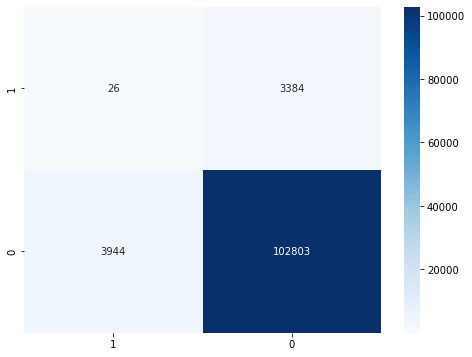

In [4]:
from matplotlib import pyplot as plt
import pandas as pd 
import seaborn as sn

df_cm = pd.DataFrame([[26, 3384],[3944, 102803]], index = [i for i in "10"], columns = [i for i in "10"])
plt.figure(figsize = (8,6))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

Since the mean accuracy is 100% on the train set and 95% on the test set, let us safely assume that the model is overfitting

A lot of values that should be marked as 1 are marked as 0 which is real bad for this model

In [164]:
feature_impt = pd.DataFrame(rf_clf.feature_importances_, index=train_set.columns).sort_values(by=0, ascending=False)
feature_impt

,0
name,
ICULOS,0.052089
ICULOS,0.051897
Temp,0.044193
preLOS,0.040521
WBC,0.037242
...,...
has_depression,0.000000
has_liver_failure,0.000000
has_myeloblastic_leukemia,0.000000


In [165]:
impt_features = feature_impt.loc[feature_impt[0] > 0.005]
impt_features_list = list(impt_features.index.values)
impt_features

,0
name,
ICULOS,0.052089
ICULOS,0.051897
Temp,0.044193
preLOS,0.040521
WBC,0.037242
Platelets,0.035675
Glucose,0.035318
HR,0.033959
Hct,0.033346


In [166]:
non_impt_features = feature_impt.loc[feature_impt[0] <= 0.005]
non_impt_features_list = list(non_impt_features.index.values)
non_impt_features

,0
name,
has_hypothyroidism,0.004958
on_anticoagulants,0.004938
WBCSIRS,0.004850
has_coma,0.004837
has_cerebral_infarction,0.004746
...,...
has_depression,0.000000
has_liver_failure,0.000000
has_myeloblastic_leukemia,0.000000


In [167]:
import matplotlib.pyplot as plt
import seaborn as sns

In [168]:
def plot_feature_importance(importance,names,model_type):
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    # important features
    fi_df = fi_df.loc[fi_df['feature_importance'] > 0.005]

    #Define size of bar plot
    plt.figure(figsize=(15,10))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

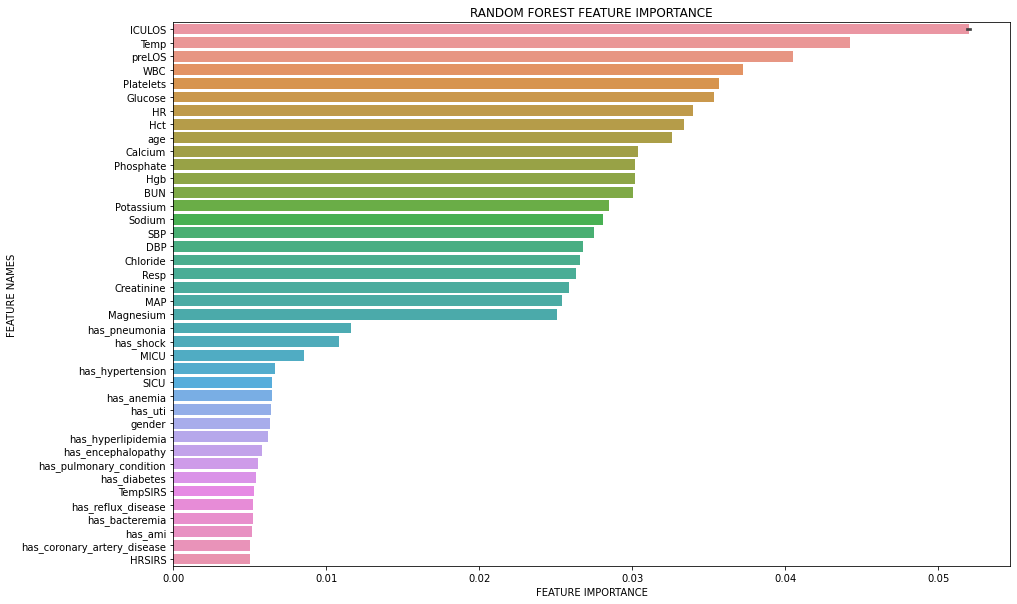

In [169]:
plot_feature_importance(rf_clf.feature_importances_,train_set.columns,'RANDOM FOREST')

In [170]:
train_set, train_labels = train_structured_data_df_clean.drop(columns = ['Sepsis', 'patient_id', 'time'] + non_impt_features_list), train_structured_data_df_clean['Sepsis']
valid_set, valid_labels = valid_structured_data_df_clean.drop(columns = ['Sepsis', 'patient_id', 'time'] + non_impt_features_list), valid_structured_data_df_clean['Sepsis']


In [171]:
del feature_impt
del impt_features
del non_impt_features

In [172]:
rf_clf = RandomForestClassifier()
rf_clf.fit(train_set, train_labels)

RandomForestClassifier()

In [173]:
predictions = rf_clf.predict(valid_set)

print("Train set score: ", rf_clf.score(train_set, train_labels))
print("Test set score: ", rf_clf.score(valid_set, valid_labels))

print("Confusion matrix: ")
cm = confusion_matrix(valid_labels, predictions,  labels = [1, 0])
print(cm)

TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("Sensitivity, hit rate, recall, or true positive rate: ", TPR)

# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("Specificity or true negative rate: ", TNR)

# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Precision or positive predictive value: ", PPV)

# Negative predictive value
NPV = TN/(TN+FN)
print("Negative predictive value: ", NPV)

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("Fall out or false positive rate: ", FPR)

# False negative rate
FNR = FN/(TP+FN)
print("False negative rate: ", FNR)

# False discovery rate
FDR = FP/(TP+FP)
print("False discovery rate: ", FDR)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall accuracy: ", ACC)

# AUC, PPV, NPV, Sensitivity, Specificity

Train set score:  0.9999897445364018
Test set score:  0.8978821137104315
Confusion matrix: 
[[   64  3346]
 [ 7903 98844]]
Sensitivity, hit rate, recall, or true positive rate:  0.008033136688841471
Specificity or true negative rate:  0.9672570701634211
Precision or positive predictive value:  0.0187683284457478
Negative predictive value:  0.9259651325095787
Fall out or false positive rate:  0.03274292983657892
False negative rate:  0.9919668633111586
False discovery rate:  0.9812316715542522
Overall accuracy:  0.8978821137104315


In [4]:
feature_columns = list(train_structured_data_df_clean.columns)
feature_columns.remove('patient_id')
feature_columns.remove('time')
feature_columns.remove('Sepsis')

NameError: name 'train_structured_data_df_clean' is not defined

In [18]:
# remove this to get previous results
feature_columns = [col for col in feature_columns if col not in non_impt_features_list]

NameError: name 'non_impt_features_list' is not defined

In [11]:
len(feature_columns)

105

In [12]:
# current sequence generation code
def create_sequence_data(df, feature_columns, y_label='y'):
    
    id_list = df['patient_id'].unique()
    
    x_sequence = []
    y_local = []
    ids = []

    for idx in id_list:
        x_sequence.append(df[df['patient_id'] == idx][feature_columns].values.tolist())
        y_local.append(df[df['patient_id'] == idx][y_label].max())
        ids.append(idx)

    return x_sequence, y_local, ids

In [13]:
X_train, y_train, id_ls_train = create_sequence_data(train_structured_data_df_clean, feature_columns, 'Sepsis')

In [14]:
X_valid, y_valid, id_ls_valid = create_sequence_data(valid_structured_data_df_clean, feature_columns, 'Sepsis')

In [15]:
# Pad and truncate the data
def pad_trunc(data, max_len):
    new_data = []
    zero_vec = []
    for _ in range(len(data[0][0])):
        zero_vec.append(0.0)
    
    for sample in data:
        if len(sample) > max_len: # truncate 
            temp = sample[:max_len]
        elif len(sample) < max_len:
            temp = sample
            number_additonal_elements = max_len - len(sample)
            for _ in range(number_additonal_elements):
                temp.append(zero_vec)
        else:
            temp = sample
    
        new_data.append(temp)
    
    return new_data

In [16]:
print(len(X_train), len(X_train[0]), len(X_train[0][0]))
maxLen = 0
for i in X_train:
    maxLen = max(maxLen, len(i))
print(maxLen)

1972 83 107
402


In [17]:
max_len = 402 # 500
batch_size = 32
embedding_dim = 107 # number of features # 107

X_train = pad_trunc(X_train, max_len)
X_valid = pad_trunc(X_valid, max_len)

# Reshape x_train and x_test
X_train = np.reshape(X_train, (len(X_train), max_len, embedding_dim))
X_valid = np.reshape(X_valid, (len(X_valid), max_len, embedding_dim))

y_train = np.array(y_train)
y_valid = np.array(y_valid)

print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)

(1972, 402, 107) (1972,) (1468, 402, 107) (1468,)


In [6]:
from keras.preprocessing import sequence 

from keras.models import Sequential 

from keras.layers import Conv1D, GlobalMaxPooling1D, Dense, Dropout, Activation
from keras.layers import Flatten, LSTM

from keras.models import model_from_json

In [18]:
# Hyperparameters
filters = 16
kernel_size = 3
strides = 1
hidden_dims = 280
epochs = 50

# Build CNN layers using Tensorflow
model=Sequential()
model.add(Conv1D(filters=filters, kernel_size=kernel_size, padding='valid', activation='relu', strides=strides, input_shape=[max_len,embedding_dim]))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims)) # in this layer after applying the pooling we have 1D vector for each training sample 
model.add(Dropout(0.2)) # adding drop out on feed forward layer and not a convolution 
model.add(Activation('relu'))
model.add(Dense(1)) # output layer
model.add(Activation('sigmoid'))

# Compile the CNN
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 400, 16)           5152      
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 280)               4760      
                                                                 
 dropout (Dropout)           (None, 280)               0         
                                                                 
 activation (Activation)     (None, 280)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 281       
                                                        

2022-12-06 00:32:03.296385: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-06 00:32:03.296454: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-70-211.us-west-2.compute.internal): /proc/driver/nvidia/version does not exist
2022-12-06 00:32:03.299290: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [19]:
# Train the model 
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/50
62/62 [==============================] - 3s 35ms/step - loss: 1.6320 - accuracy: 0.6268 - val_loss: 2.7449 - val_accuracy: 0.7834
Epoch 2/50
62/62 [==============================] - 2s 27ms/step - loss: 0.6880 - accuracy: 0.7059 - val_loss: 0.4956 - val_accuracy: 0.7984
Epoch 3/50
62/62 [==============================] - 2s 27ms/step - loss: 0.5450 - accuracy: 0.7500 - val_loss: 1.6549 - val_accuracy: 0.7807
Epoch 4/50
62/62 [==============================] - 2s 27ms/step - loss: 0.5332 - accuracy: 0.7576 - val_loss: 8.2476 - val_accuracy: 0.8481
Epoch 5/50
62/62 [==============================] - 2s 27ms/step - loss: 0.5141 - accuracy: 0.7759 - val_loss: 3.5206 - val_accuracy: 0.8440
Epoch 6/50
62/62 [==============================] - 2s 27ms/step - loss: 0.4914 - accuracy: 0.7845 - val_loss: 3.1974 - val_accuracy: 0.8638
Epoch 7/50
62/62 [==============================] - 2s 28ms/step - loss: 0.4950 - accuracy: 0.7804 - val_loss: 5.8777 - val_accuracy: 0.8624
Epoch 8/50
62

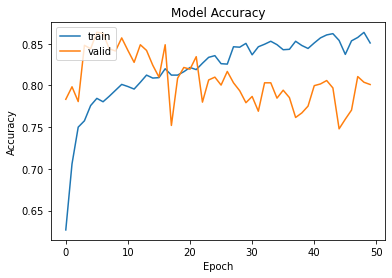

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

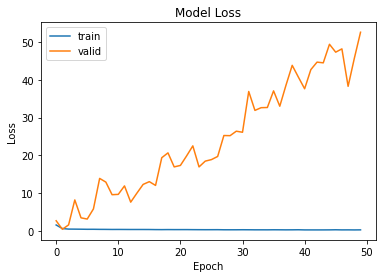

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [18]:
# Hyperparameters
filters = 16
kernel_size = 3
strides = 1
hidden_dims = 280
epochs = 6

# Build CNN layers using Tensorflow
model=Sequential()
model.add(Conv1D(filters=filters, kernel_size=kernel_size, padding='valid', activation='relu', strides=strides, input_shape=[max_len,embedding_dim]))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims)) # in this layer after applying the pooling we have 1D vector for each training sample 
model.add(Dropout(0.2)) # adding drop out on feed forward layer and not a convolution 
model.add(Activation('relu'))
model.add(Dense(1)) # output layer
model.add(Activation('sigmoid'))

# Compile the CNN
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


2022-12-06 01:49:33.390811: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-06 01:49:33.390885: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-79-154.us-west-2.compute.internal): /proc/driver/nvidia/version does not exist
2022-12-06 01:49:33.408225: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


NameError: name 'max_len' is not defined

In [27]:
# Train the model 
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid))

# Save the model 
model_str = model.to_json()
with open('cnn_model.json','w') as json_file:
    json_file.write(model_str)
model.save_weights('cnn_weights.h5')

Epoch 1/6
62/62 [==============================] - 2s 34ms/step - loss: 1.6788 - accuracy: 0.6197 - val_loss: 0.5217 - val_accuracy: 0.7841
Epoch 2/6
62/62 [==============================] - 2s 27ms/step - loss: 0.6596 - accuracy: 0.7033 - val_loss: 0.5681 - val_accuracy: 0.7663
Epoch 3/6
62/62 [==============================] - 2s 27ms/step - loss: 0.6122 - accuracy: 0.7282 - val_loss: 2.4975 - val_accuracy: 0.7248
Epoch 4/6
62/62 [==============================] - 2s 27ms/step - loss: 0.5639 - accuracy: 0.7419 - val_loss: 1.2805 - val_accuracy: 0.6757
Epoch 5/6
62/62 [==============================] - 2s 27ms/step - loss: 0.5538 - accuracy: 0.7414 - val_loss: 2.7206 - val_accuracy: 0.8283
Epoch 6/6
62/62 [==============================] - 2s 27ms/step - loss: 0.5502 - accuracy: 0.7596 - val_loss: 1.1301 - val_accuracy: 0.8358


In [28]:
# Import the saved model
with open("cnn_model.json",'r') as json_file:
    json_string = json_file.read()

model = model_from_json(json_string)
model.load_weights('cnn_weights.h5')

predictions = model.predict(X_valid)

In [29]:
pred_label = [1 if i > 0.5 else 0 for i in predictions]

In [32]:
print("Confusion matrix: ")
cm = confusion_matrix(y_valid, pred_label,  labels = [1, 0])
print(cm)

TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("Sensitivity, hit rate, recall, or true positive rate: ", TPR)

# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("Specificity or true negative rate: ", TNR)

# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Precision or positive predictive value: ", PPV)

# Negative predictive value
NPV = TN/(TN+FN)
print("Negative predictive value: ", NPV)

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("Fall out or false positive rate: ", FPR)

# False negative rate
FNR = FN/(TP+FN)
print("False negative rate: ", FNR)

# False discovery rate
FDR = FP/(TP+FP)
print("False discovery rate: ", FDR)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall accuracy: ", ACC)

# AUC, PPV, NPV, Sensitivity, Specificity

Confusion matrix: 
[[363 146]
 [ 95 864]]
Sensitivity, hit rate, recall, or true positive rate:  0.7925764192139738
Specificity or true negative rate:  0.8554455445544554
Precision or positive predictive value:  0.7131630648330058
Negative predictive value:  0.9009384775808134
Fall out or false positive rate:  0.14455445544554454
False negative rate:  0.2074235807860262
False discovery rate:  0.2868369351669941
Overall accuracy:  0.8358310626702997


<AxesSubplot:>

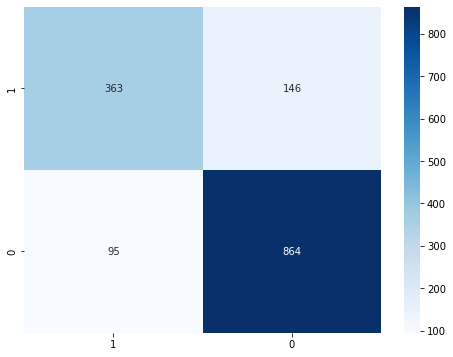

In [33]:
df_cm = pd.DataFrame([[363, 146],[95, 864]], index = [i for i in "10"], columns = [i for i in "10"])
plt.figure(figsize = (8,6))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [22]:
# Hyperparameters. Structured data will have different input dimensions based on number of features x time points
num_neurons = 50
epochs = 50

# This line may not be necessary for kernels other than conda_tensorflow2_p38
tf.keras.backend.set_image_data_format("channels_last")

# Initialize network with Sequential keras model
model = Sequential()
model.add(LSTM(num_neurons, input_shape=(max_len, embedding_dim), return_sequences=True)) # output 100 *50
model.add(Dropout(0.2))
model.add(Flatten()) # for output with rank > 2
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile('RMSprop', 'binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 402, 50)           31600     
                                                                 
 dropout_1 (Dropout)         (None, 402, 50)           0         
                                                                 
 flatten (Flatten)           (None, 20100)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 20101     
                                                                 
Total params: 51,701
Trainable params: 51,701
Non-trainable params: 0
_________________________________________________________________
None


In [23]:
# Train the model 
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid))

Epoch 1/50
62/62 [==============================] - 15s 221ms/step - loss: 0.5434 - accuracy: 0.7657 - val_loss: 0.5862 - val_accuracy: 0.7330
Epoch 2/50
62/62 [==============================] - 13s 209ms/step - loss: 0.5103 - accuracy: 0.7789 - val_loss: 0.3729 - val_accuracy: 0.8576
Epoch 3/50
62/62 [==============================] - 13s 209ms/step - loss: 0.4934 - accuracy: 0.7906 - val_loss: 0.4681 - val_accuracy: 0.8031
Epoch 4/50
62/62 [==============================] - 13s 211ms/step - loss: 0.4787 - accuracy: 0.7896 - val_loss: 0.3709 - val_accuracy: 0.8597
Epoch 5/50
62/62 [==============================] - 13s 212ms/step - loss: 0.4694 - accuracy: 0.7961 - val_loss: 0.3722 - val_accuracy: 0.8576
Epoch 6/50
62/62 [==============================] - 13s 212ms/step - loss: 0.4542 - accuracy: 0.8002 - val_loss: 0.4156 - val_accuracy: 0.8202
Epoch 7/50
62/62 [==============================] - 13s 211ms/step - loss: 0.4463 - accuracy: 0.8017 - val_loss: 0.4312 - val_accuracy: 0.8065

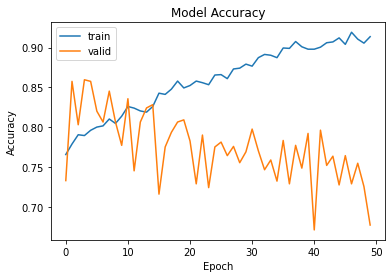

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

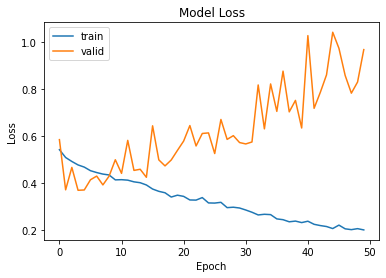

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [34]:
# Hyperparameters. Structured data will have different input dimensions based on number of features x time points
num_neurons = 50
epochs = 4

# This line may not be necessary for kernels other than conda_tensorflow2_p38
tf.keras.backend.set_image_data_format("channels_last")

# Initialize network with Sequential keras model
model = Sequential()
model.add(LSTM(num_neurons, input_shape=(max_len, embedding_dim), return_sequences=True)) # output 100 *50
model.add(Dropout(0.2))
model.add(Flatten()) # for output with rank > 2
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile('RMSprop', 'binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 402, 50)           31600     
                                                                 
 dropout_3 (Dropout)         (None, 402, 50)           0         
                                                                 
 flatten_1 (Flatten)         (None, 20100)             0         
                                                                 
 dense_5 (Dense)             (None, 1)                 20101     
                                                                 
Total params: 51,701
Trainable params: 51,701
Non-trainable params: 0
_________________________________________________________________
None


In [35]:
# Train the model 
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, y_valid))

# Save the model 
model_str = model.to_json()
with open('lstm_model.json','w') as json_file:
    json_file.write(model_str)
model.save_weights('lstm_weights.h5')

Epoch 1/4
62/62 [==============================] - 16s 225ms/step - loss: 0.5483 - accuracy: 0.7566 - val_loss: 0.3990 - val_accuracy: 0.8535
Epoch 2/4
62/62 [==============================] - 13s 212ms/step - loss: 0.5094 - accuracy: 0.7743 - val_loss: 0.4370 - val_accuracy: 0.8249
Epoch 3/4
62/62 [==============================] - 13s 212ms/step - loss: 0.4902 - accuracy: 0.7845 - val_loss: 0.3908 - val_accuracy: 0.8467
Epoch 4/4
62/62 [==============================] - 13s 213ms/step - loss: 0.4828 - accuracy: 0.7890 - val_loss: 0.3934 - val_accuracy: 0.8495


In [36]:
# Import the saved model
with open("lstm_model.json",'r') as json_file:
    json_string = json_file.read()

model = model_from_json(json_string)
model.load_weights('lstm_weights.h5')

predictions = model.predict(X_valid)

In [37]:
pred_label = [1 if i > 0.5 else 0 for i in predictions]

In [38]:
print("Confusion matrix: ")
cm = confusion_matrix(y_valid, pred_label,  labels = [1, 0])
print(cm)

TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("Sensitivity, hit rate, recall, or true positive rate: ", TPR)

# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("Specificity or true negative rate: ", TNR)

# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Precision or positive predictive value: ", PPV)

# Negative predictive value
NPV = TN/(TN+FN)
print("Negative predictive value: ", NPV)

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("Fall out or false positive rate: ", FPR)

# False negative rate
FNR = FN/(TP+FN)
print("False negative rate: ", FNR)

# False discovery rate
FDR = FP/(TP+FP)
print("False discovery rate: ", FDR)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall accuracy: ", ACC)

# AUC, PPV, NPV, Sensitivity, Specificity

Confusion matrix: 
[[365 144]
 [ 77 882]]
Sensitivity, hit rate, recall, or true positive rate:  0.8257918552036199
Specificity or true negative rate:  0.8596491228070176
Precision or positive predictive value:  0.7170923379174853
Negative predictive value:  0.9197080291970803
Fall out or false positive rate:  0.14035087719298245
False negative rate:  0.17420814479638008
False discovery rate:  0.2829076620825147
Overall accuracy:  0.8494550408719346


<AxesSubplot:>

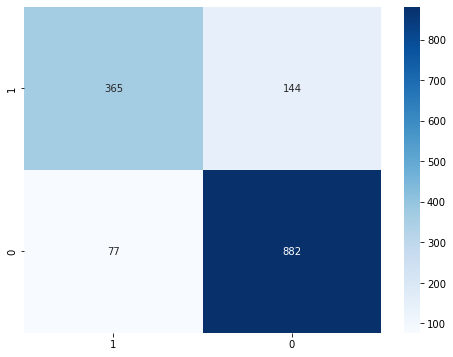

In [39]:
df_cm = pd.DataFrame([[365, 144],[77, 882]], index = [i for i in "10"], columns = [i for i in "10"])
plt.figure(figsize = (8,6))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [7]:
# How to get representations? See the Chapter 6 exercise on how to use Word2Vec to process biomedical text
!pip install -U gensim

import nltk
# nltk.download('stopwords')

from gensim.models.keyedvectors import KeyedVectors

from nltk.tokenize import TreebankWordTokenizer
stopwords = nltk.corpus.stopwords.words('english')

word_vectors_pubmed = KeyedVectors.load_word2vec_format('s3://med-277/Labs/pubmed2018_w2v_200D.bin', binary=True, limit=200000)

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.


In [6]:
# Tokenize and vectorize the data
def tokenizer_and_vectroizer(text):
    tokenizer = TreebankWordTokenizer()
    vectorized_data = []
    expected = []
    
    # Remove numbers and punctuation
    text = ''.join([ch.lower() for ch in text if ch.isalpha() or ch == " "]) 

    # Tokenize the note
    tokens = tokenizer.tokenize(re.sub(r'[^\w\s]','',text))

    # Remove stopwords
    tokens_clean = [w for w in tokens if not w in stopwords]

    # Remove words with length 1
    tokens_clean = [w for w in tokens_clean if len(w) > 1]

    vectorized_data = []
    for token in tokens:
        try:    
            vectorized_data.append(word_vectors_pubmed[token])
        except:
            pass
            
    return vectorized_data

In [21]:
del train_data_df_clean
del valid_data_df_clean

In [22]:
del train_structured_data_df_clean
del valid_structured_data_df_clean

In [23]:
x_train_seq_wtext = X_train[:]
x_valid_seq_wtext = X_valid[:]

In [24]:
del X_train
del X_valid

In [25]:
cnt = 0
for patient in x_train_seq_wtext:
    for row in patient:
        vectorized_tokens = tokenizer_and_vectroizer(train_text_data_df_clean[cnt])
        if not vectorized_tokens:
            row.extend([0] * 200)
            continue
        vectorized_tokens = np.array(vectorized_tokens)
        vectorized_tokens = vectorized_tokens.mean(axis=0)
        row.extend(vectorized_tokens)
        cnt += 1

In [26]:
cnt = 0
for patient in x_valid_seq_wtext:
    for row in patient:
        vectorized_tokens = tokenizer_and_vectroizer(valid_text_data_df_clean[cnt])
        if not vectorized_tokens:
            row.extend([0] * 200)
            continue
        vectorized_tokens = np.array(vectorized_tokens)
        vectorized_tokens = vectorized_tokens.mean(axis=0)
        row.extend(vectorized_tokens)
        cnt += 1

In [27]:
print(x_train_seq_wtext[0][0])

[85.36631097499881, 36.9386943426975, 121.78996661337457, 79.27404637452362, 63.92428738214118, 19.311585458996085, 24.373042170377825, 7.715338702004022, 104.48631425691566, 1.580396475771007, 123.0, 2.0807061968065828, 3.3982078208539073, 5.0, 20.0, 6.7, 11.524149704229972, 195.07442870201098, 138.02054250114747, 24.0, 0.0, 1.0, 1.0, -1.0, -1.0, -9.069722222222222, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [28]:
print(x_valid_seq_wtext[0][0])

[93.0, 33.71, 121.91961734384762, 71.5, 62.733472951131596, 21.0, 30.35900401978079, 5.012499999999998, 103.48590476737837, 1.7256725077655233, 142.60530052058684, 2.1216519938362417, 3.519760757502272, 3.0, 30.096346821254173, 38.666609213108266, 12.56296357295155, 219.70787463328202, 147.61621875119636, 41.0, 0.0, 1.0, 1.0, 1.0, 0.0, -3.1666666666666665, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [8]:
del train_text_data_df_clean
del valid_text_data_df_clean
del word_vectors_pubmed
del stopwords

NameError: name 'train_text_data_df_clean' is not defined

In [30]:
print(len(x_train_seq_wtext))
print(len(x_train_seq_wtext[0]))
print(len(x_train_seq_wtext[0][0]))

maxLen = 0
for i in x_train_seq_wtext:
    temp = len(i)
    if temp > maxLen:
        print(temp)
    maxLen = max(maxLen, temp)

1972
83
307
83
105
111
117
143
223
307
402


In [10]:
max_len = 402
batch_size = 8 #32
embedding_dim = 307 # number of features # 307

In [31]:
x_train_seq_wtext = pad_trunc(x_train_seq_wtext, max_len)
x_valid_seq_wtext = pad_trunc(x_valid_seq_wtext, max_len)

In [32]:
# Reshape x_train and x_test
x_train_seq_wtext = np.reshape(x_train_seq_wtext, (len(x_train_seq_wtext), max_len, embedding_dim))

In [33]:
x_valid_seq_wtext = np.reshape(x_valid_seq_wtext, (len(x_valid_seq_wtext), max_len, embedding_dim))

In [34]:
x_valid = np.array(y_train)
y_valid = np.array(y_valid)

In [35]:
print(x_train_seq_wtext.shape, y_train.shape, x_valid_seq_wtext.shape, y_valid.shape)

(1972, 402, 307) (1972,) (1468, 402, 307) (1468,)


In [36]:
np.save('x_train_seq_wtext.npy', x_train_seq_wtext)
np.save('x_valid_seq_wtext.npy', x_valid_seq_wtext)
np.save('y_train_wtext.npy', y_train)
np.save('y_valid_wtext.npy', y_valid)

In [9]:
x_train_seq_wtext = np.load('x_train_seq_wtext.npy')
x_valid_seq_wtext = np.load('x_valid_seq_wtext.npy')
y_train = np.load('y_train_wtext.npy')
y_valid = np.load('y_valid_wtext.npy')

In [61]:
# Hyperparameters
filters = 16
kernel_size = 3
strides = 1
hidden_dims = 280
epochs = 50

# Build CNN layers using Tensorflow
model=Sequential()
model.add(Conv1D(filters=filters, kernel_size=kernel_size, padding='valid', activation='relu', strides=strides, input_shape=[max_len,embedding_dim]))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims)) # in this layer after applying the pooling we have 1D vector for each training sample 
model.add(Dropout(0.2)) # adding drop out on feed forward layer and not a convolution 
model.add(Activation('relu'))
model.add(Dense(1)) # output layer
model.add(Activation('sigmoid'))

# Compile the CNN
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 400, 16)           14752     
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 280)               4760      
                                                                 
 dropout (Dropout)           (None, 280)               0         
                                                                 
 activation (Activation)     (None, 280)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 281       
                                                        

2022-12-06 01:58:28.829474: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-06 01:58:28.829552: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-79-154.us-west-2.compute.internal): /proc/driver/nvidia/version does not exist
2022-12-06 01:58:28.832524: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [62]:
# Train the model 
history = model.fit(x_train_seq_wtext, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid_seq_wtext, y_valid))

2022-12-06 01:58:29.382413: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 973489632 exceeds 10% of free system memory.


Epoch 1/50
124/124 [==============================] - ETA: 0s - loss: 0.7645 - accuracy: 0.6526

2022-12-06 01:58:35.927147: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 724687008 exceeds 10% of free system memory.


124/124 [==============================] - 7s 53ms/step - loss: 0.7645 - accuracy: 0.6526 - val_loss: 8.6121 - val_accuracy: 0.7738
Epoch 2/50
124/124 [==============================] - 5s 43ms/step - loss: 0.6028 - accuracy: 0.7282 - val_loss: 13.0360 - val_accuracy: 0.8222
Epoch 3/50
124/124 [==============================] - 5s 43ms/step - loss: 0.5582 - accuracy: 0.7535 - val_loss: 17.3196 - val_accuracy: 0.8454
Epoch 4/50
124/124 [==============================] - 5s 42ms/step - loss: 0.5296 - accuracy: 0.7591 - val_loss: 16.8681 - val_accuracy: 0.8447
Epoch 5/50
124/124 [==============================] - 5s 43ms/step - loss: 0.5164 - accuracy: 0.7698 - val_loss: 11.9360 - val_accuracy: 0.8495
Epoch 6/50
124/124 [==============================] - 5s 43ms/step - loss: 0.4994 - accuracy: 0.7754 - val_loss: 15.3817 - val_accuracy: 0.8583
Epoch 7/50
124/124 [==============================] - 5s 43ms/step - loss: 0.4965 - accuracy: 0.7830 - val_loss: 24.0809 - val_accuracy: 0.8542
Epoc

KeyboardInterrupt: 

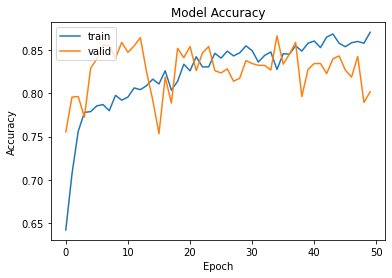

In [36]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

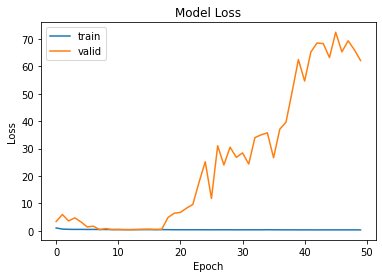

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [37]:
# Hyperparameters
filters = 16
kernel_size = 3
strides = 1
hidden_dims = 280
epochs = 10

# Build CNN layers using Tensorflow
model=Sequential()
model.add(Conv1D(filters=filters, kernel_size=kernel_size, padding='valid', activation='relu', strides=strides, input_shape=[max_len,embedding_dim]))
model.add(GlobalMaxPooling1D())
model.add(Dense(hidden_dims)) # in this layer after applying the pooling we have 1D vector for each training sample 
model.add(Dropout(0.2)) # adding drop out on feed forward layer and not a convolution 
model.add(Activation('relu'))
model.add(Dense(1)) # output layer
model.add(Activation('sigmoid'))

# Compile the CNN
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())


2022-12-06 02:29:35.778589: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-12-06 02:29:35.778663: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-79-154.us-west-2.compute.internal): /proc/driver/nvidia/version does not exist
2022-12-06 02:29:35.785506: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 400, 16)           14752     
                                                                 
 global_max_pooling1d (Globa  (None, 16)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 280)               4760      
                                                                 
 dropout (Dropout)           (None, 280)               0         
                                                                 
 activation (Activation)     (None, 280)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 281       
                                                        

In [38]:
# Train the model 
model.fit(x_train_seq_wtext, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid_seq_wtext, y_valid))

# Save the model 
model_str = model.to_json()
with open('cnn_model_wtext.json','w') as json_file:
    json_file.write(model_str)
model.save_weights('cnn_weights_wtext.h5')

2022-12-06 02:29:43.801940: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 973489632 exceeds 10% of free system memory.


Epoch 1/10
  6/247 [..............................] - ETA: 5s - loss: 3.0359 - accuracy: 0.6042

2022-12-06 02:29:45.453575: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30945600 exceeds 10% of free system memory.
2022-12-06 02:29:45.490243: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30945600 exceeds 10% of free system memory.
2022-12-06 02:29:45.510096: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30945600 exceeds 10% of free system memory.
2022-12-06 02:29:45.529828: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 30945600 exceeds 10% of free system memory.


247/247 [==============================] - 8s 29ms/step - loss: 0.8226 - accuracy: 0.6744 - val_loss: 11.5840 - val_accuracy: 0.8447
Epoch 2/10
247/247 [==============================] - 6s 25ms/step - loss: 0.5625 - accuracy: 0.7495 - val_loss: 17.1718 - val_accuracy: 0.8440
Epoch 3/10
247/247 [==============================] - 6s 26ms/step - loss: 0.5232 - accuracy: 0.7743 - val_loss: 6.4065 - val_accuracy: 0.8481
Epoch 4/10
247/247 [==============================] - 6s 25ms/step - loss: 0.5118 - accuracy: 0.7779 - val_loss: 6.3219 - val_accuracy: 0.8631
Epoch 5/10
247/247 [==============================] - 6s 25ms/step - loss: 0.4816 - accuracy: 0.7901 - val_loss: 11.3732 - val_accuracy: 0.8583
Epoch 6/10
247/247 [==============================] - 6s 25ms/step - loss: 0.4853 - accuracy: 0.7885 - val_loss: 4.9723 - val_accuracy: 0.8501
Epoch 7/10
247/247 [==============================] - 6s 25ms/step - loss: 0.4731 - accuracy: 0.7916 - val_loss: 12.2630 - val_accuracy: 0.8529
Epoch 

In [40]:
# Import the saved model
with open("cnn_model_wtext.json",'r') as json_file:
    json_string = json_file.read()

model = model_from_json(json_string)
model.load_weights('cnn_weights_wtext.h5')

predictions = model.predict(x_valid_seq_wtext)

In [41]:
pred_label = [1 if i > 0.5 else 0 for i in predictions]

In [42]:
print("Confusion matrix: ")
cm = confusion_matrix(y_valid, pred_label,  labels = [1, 0])
print(cm)

TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("Sensitivity, hit rate, recall, or true positive rate: ", TPR)

# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("Specificity or true negative rate: ", TNR)

# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Precision or positive predictive value: ", PPV)

# Negative predictive value
NPV = TN/(TN+FN)
print("Negative predictive value: ", NPV)

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("Fall out or false positive rate: ", FPR)

# False negative rate
FNR = FN/(TP+FN)
print("False negative rate: ", FNR)

# False discovery rate
FDR = FP/(TP+FP)
print("False discovery rate: ", FDR)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall accuracy: ", ACC)

# AUC, PPV, NPV, Sensitivity, Specificity

Confusion matrix: 
[[373 136]
 [ 70 889]]
Sensitivity, hit rate, recall, or true positive rate:  0.8419864559819413
Specificity or true negative rate:  0.8673170731707317
Precision or positive predictive value:  0.7328094302554028
Negative predictive value:  0.927007299270073
Fall out or false positive rate:  0.1326829268292683
False negative rate:  0.1580135440180587
False discovery rate:  0.26719056974459726
Overall accuracy:  0.8596730245231607


<AxesSubplot:>

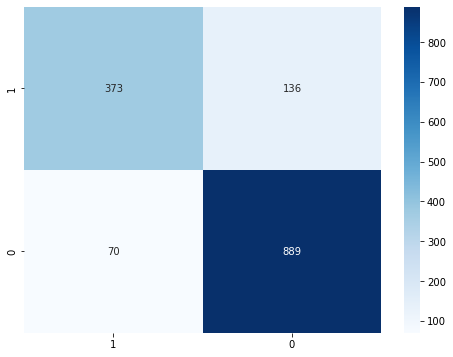

In [43]:
df_cm = pd.DataFrame([[373, 136],[70, 889]], index = [i for i in "10"], columns = [i for i in "10"])
plt.figure(figsize = (8,6))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [10]:
# Hyperparameters. Structured data will have different input dimensions based on number of features x time points
num_neurons = 50
epochs = 50

# This line may not be necessary for kernels other than conda_tensorflow2_p38
tf.keras.backend.set_image_data_format("channels_last")

# Initialize network with Sequential keras model
model = Sequential()
model.add(LSTM(num_neurons, input_shape=(max_len, embedding_dim), return_sequences=True)) # output 100 *50
model.add(Dropout(0.2))
model.add(Flatten()) # for output with rank > 2
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile('RMSprop', 'binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 402, 50)           71600     
                                                                 
 dropout (Dropout)           (None, 402, 50)           0         
                                                                 
 flatten (Flatten)           (None, 20100)             0         
                                                                 
 dense (Dense)               (None, 1)                 20101     
                                                                 
Total params: 91,701
Trainable params: 91,701
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# Train the model 
history = model.fit(x_train_seq_wtext, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid_seq_wtext, y_valid))

2022-12-06 02:39:20.800968: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 973489632 exceeds 10% of free system memory.


Epoch 1/50
247/247 [==============================] - ETA: 0s - loss: 0.5643 - accuracy: 0.7596

2022-12-06 02:40:10.209103: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 724687008 exceeds 10% of free system memory.


247/247 [==============================] - 55s 214ms/step - loss: 0.5643 - accuracy: 0.7596 - val_loss: 0.4478 - val_accuracy: 0.8188
Epoch 2/50
247/247 [==============================] - 49s 198ms/step - loss: 0.5362 - accuracy: 0.7733 - val_loss: 0.3936 - val_accuracy: 0.8576
Epoch 3/50
247/247 [==============================] - 49s 200ms/step - loss: 0.5265 - accuracy: 0.7799 - val_loss: 0.6211 - val_accuracy: 0.7623
Epoch 4/50
247/247 [==============================] - 49s 199ms/step - loss: 0.5221 - accuracy: 0.7794 - val_loss: 0.4086 - val_accuracy: 0.8644
Epoch 5/50
247/247 [==============================] - 51s 206ms/step - loss: 0.5210 - accuracy: 0.7819 - val_loss: 0.6192 - val_accuracy: 0.8065
Epoch 6/50
247/247 [==============================] - 49s 200ms/step - loss: 0.5350 - accuracy: 0.7809 - val_loss: 0.4611 - val_accuracy: 0.8283
Epoch 7/50
247/247 [==============================] - 49s 200ms/step - loss: 0.5057 - accuracy: 0.7865 - val_loss: 0.3824 - val_accuracy: 0.8

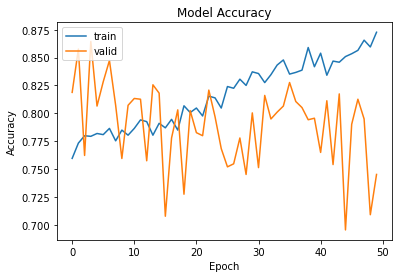

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

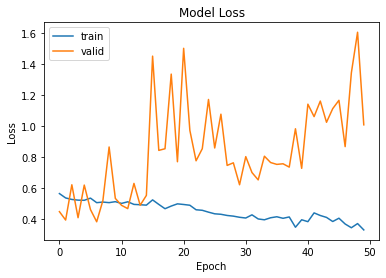

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [18]:
# Hyperparameters. Structured data will have different input dimensions based on number of features x time points
num_neurons = 50
epochs = 3

# This line may not be necessary for kernels other than conda_tensorflow2_p38
tf.keras.backend.set_image_data_format("channels_last")

# Initialize network with Sequential keras model
model = Sequential()
model.add(LSTM(num_neurons, input_shape=(max_len, embedding_dim), return_sequences=True)) # output 100 *50
model.add(Dropout(0.2))
model.add(Flatten()) # for output with rank > 2
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile('RMSprop', 'binary_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 402, 50)           71600     
                                                                 
 dropout_2 (Dropout)         (None, 402, 50)           0         
                                                                 
 flatten_2 (Flatten)         (None, 20100)             0         
                                                                 
 dense_2 (Dense)             (None, 1)                 20101     
                                                                 
Total params: 91,701
Trainable params: 91,701
Non-trainable params: 0
_________________________________________________________________
None


In [1]:
# Train the model 
model.fit(x_train_seq_wtext, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_valid_seq_wtext, y_valid))

# Save the model 
model_str = model.to_json()
with open('lstm_model_wtext.json','w') as json_file:
    json_file.write(model_str)
model.save_weights('lstm_weights_wtext.h5')

NameError: name 'model' is not defined

In [13]:
# Import the saved model
with open("lstm_model_wtext.json",'r') as json_file:
    json_string = json_file.read()

model = model_from_json(json_string)
model.load_weights('lstm_weights_wtext.h5')

predictions = model.predict(x_valid_seq_wtext)

2022-12-06 04:25:30.347114: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 724687008 exceeds 10% of free system memory.


In [14]:
pred_label = [1 if i > 0.5 else 0 for i in predictions]

In [15]:
print("Confusion matrix: ")
cm = confusion_matrix(y_valid, pred_label,  labels = [1, 0])
print(cm)

TP = cm[0][0]
FP = cm[0][1]
FN = cm[1][0]
TN = cm[1][1]

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print("Sensitivity, hit rate, recall, or true positive rate: ", TPR)

# Specificity or true negative rate
TNR = TN/(TN+FP) 
print("Specificity or true negative rate: ", TNR)

# Precision or positive predictive value
PPV = TP/(TP+FP)
print("Precision or positive predictive value: ", PPV)

# Negative predictive value
NPV = TN/(TN+FN)
print("Negative predictive value: ", NPV)

# Fall out or false positive rate
FPR = FP/(FP+TN)
print("Fall out or false positive rate: ", FPR)

# False negative rate
FNR = FN/(TP+FN)
print("False negative rate: ", FNR)

# False discovery rate
FDR = FP/(TP+FP)
print("False discovery rate: ", FDR)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print("Overall accuracy: ", ACC)

# AUC, PPV, NPV, Sensitivity, Specificity

Confusion matrix: 
[[357 152]
 [196 763]]
Sensitivity, hit rate, recall, or true positive rate:  0.6455696202531646
Specificity or true negative rate:  0.833879781420765
Precision or positive predictive value:  0.7013752455795678
Negative predictive value:  0.7956204379562044
Fall out or false positive rate:  0.16612021857923498
False negative rate:  0.35443037974683544
False discovery rate:  0.29862475442043224
Overall accuracy:  0.7629427792915532


<AxesSubplot:>

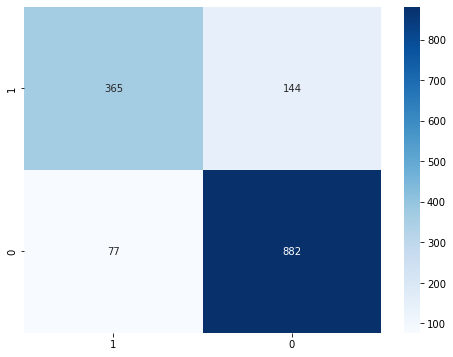

In [39]:
df_cm = pd.DataFrame([[365, 144],[77, 882]], index = [i for i in "10"], columns = [i for i in "10"])
plt.figure(figsize = (8,6))
sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')

In [ ]:
Train set score:  1.0
Test set score:  0.9504573573732353
Confusion matrix: 
[[    3   929]
 [    8 17973]]
Sensitivity, hit rate, recall, or true positive rate:  0.2727272727272727
Specificity or true negative rate:  0.9508517617183366
Precision or positive predictive value:  0.003218884120171674
Negative predictive value:  0.999555085924031
Fall out or false positive rate:  0.049148238281663315
False negative rate:  0.7272727272727273
False discovery rate:  0.9967811158798283
Overall accuracy:  0.9504573573732353
    
Train set score:  1.0
Test set score:  0.950245862634167
Confusion matrix: 
[[   10   922]
 [   19 17962]]
Sensitivity, hit rate, recall, or true positive rate:  0.3448275862068966
Specificity or true negative rate:  0.9511755983901716
Precision or positive predictive value:  0.01072961373390558
Negative predictive value:  0.9989433290695734
Fall out or false positive rate:  0.04882440160982843
False negative rate:  0.6551724137931034
False discovery rate:  0.9892703862660944
Overall accuracy:  0.950245862634167
    
CNN
Confusion matrix: 
[[ 36  85]
 [ 14 258]]
Sensitivity, hit rate, recall, or true positive rate:  0.72
Specificity or true negative rate:  0.7521865889212828
Precision or positive predictive value:  0.2975206611570248
Negative predictive value:  0.9485294117647058
Fall out or false positive rate:  0.2478134110787172
False negative rate:  0.28
False discovery rate:  0.7024793388429752
Overall accuracy:  0.7480916030534351
    
Confusion matrix: 
[[ 67  54]
 [ 34 238]]
Sensitivity, hit rate, recall, or true positive rate:  0.6633663366336634
Specificity or true negative rate:  0.815068493150685
Precision or positive predictive value:  0.5537190082644629
Negative predictive value:  0.875
Fall out or false positive rate:  0.18493150684931506
False negative rate:  0.33663366336633666
False discovery rate:  0.4462809917355372
Overall accuracy:  0.7760814249363868
    
LSTM
Confusion matrix: 
[[ 54  67]
 [ 19 253]]
Sensitivity, hit rate, recall, or true positive rate:  0.7397260273972602
Specificity or true negative rate:  0.790625
Precision or positive predictive value:  0.4462809917355372
Negative predictive value:  0.9301470588235294
Fall out or false positive rate:  0.209375
False negative rate:  0.2602739726027397
False discovery rate:  0.5537190082644629
Overall accuracy:  0.7811704834605598
    
Confusion matrix: 
[[ 76  45]
 [ 66 206]]
Sensitivity, hit rate, recall, or true positive rate:  0.5352112676056338
Specificity or true negative rate:  0.8207171314741036
Precision or positive predictive value:  0.628099173553719
Negative predictive value:  0.7573529411764706
Fall out or false positive rate:  0.17928286852589642
False negative rate:  0.4647887323943662
False discovery rate:  0.371900826446281
Overall accuracy:  0.7175572519083969

In [ ]:
# How to train a model? See the Chapter 8 exercise on how to compile a RNN using Tensorflow. You also might consider using an LSTM (see below).
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, LSTM

# Hyperparameters. Structured data will have different input dimensions based on number of features x time points
maxlen = 100
embedding_dim = 300
batch_size = 32
num_neurons = 50
epochs = 2

# This line may not be necessary for kernels other than conda_tensorflow2_p38
tf.keras.backend.set_image_data_format("channels_last")

# Initialize network with Sequential keras model
model = Sequential()
model.add(LSTM(num_neurons, input_shape=(maxlen, embedding_dim), return_sequences=True)) # output 100 *50
model.add(Dropout(0.2))
model.add(Flatten()) # for output with rank > 2
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile('RMSprop', 'binary_crossentropy', metrics=['accuracy'])
print(model.summary())

### YOUR CODE HERE

## Recommendations for the final project using sepsis labels
### 1) Train a RNN/LSTM on the structured data separately. Evaluate model using standard metrics (e.g. AUC, PPV, NPV, Sensitivity, Specificity)
### 2) Use Word2Vec to generate representations from the reports
### 3) Append representations to trained neural network and evaluate model performance.